In [ ]:
! pip install librosa scipy
! pip install pysptk
! pip install praat-parselmouth
!pip install --upgrade scipy


  Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.2 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.


In [ ]:

import librosa
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, Dropout, Attention
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    accuracy_score,  # For calculating accuracy
    roc_auc_score,   # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)
import scipy
from scipy.io import wavfile
from tqdm import tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import scipy
print(scipy.__version__)


1.13.1


In [ ]:
drive_path = "/content/drive/Shareddrives/CS298/CS 297/EMOV"

In [ ]:
folders = os.listdir(drive_path)

# Print the names of the folders
for folder in folders:
    print(folder)

bea_Amused
bea_Disgusted
bea_Angry
bea_Sleepy
bea_Neutral
jenie_Angry
jenie_Amused
jenie_Disgusted
jenie_Neutral
jenie_Sleepy
josh_Amused
josh_Neutral
josh_Sleepy
sam_Amused
sam_Disgusted
sam_Angry
sam_Neutral
sam_Sleepy


In [ ]:


# Initialize lists to store data
audio_paths = []
emotions = []

# Iterate through each folder
for folder in os.listdir(drive_path):
    folder_path = os.path.join(drive_path, folder)
    if os.path.isdir(folder_path):
        # Get the emotion category from the folder name
        if "Sleepy" in folder:
            emotion = "Sleepy"
        elif "Amused" in folder:
            emotion = "Amused"
        elif "Disgusted" in folder:
            emotion = "Disgusted"
        elif "Angry" in folder:
            emotion = "Angry"
        elif "Neutral" in folder:
            emotion = "Neutral"
        else:
            emotion = "Unknown"

        # Iterate through audio files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".wav"):
                audio_paths.append(os.path.join(folder_path, file_name))
                emotions.append(emotion)

# Create a DataFrame
data = {"audio_path": audio_paths, "emotion": emotions}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                                             audio_path emotion
0     /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Amused
1     /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Amused
2     /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Amused
3     /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Amused
4     /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Amused
...                                                 ...     ...
6888  /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Sleepy
6889  /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Sleepy
6890  /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Sleepy
6891  /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Sleepy
6892  /content/drive/Shareddrives/CS298/CS 297/EMOV/...  Sleepy

[6893 rows x 2 columns]


In [ ]:
def get_audio_properties(audio_path):
    y, sr = librosa.load(audio_path, sr=None, mono=False)
    channels = 1 if y.ndim == 1 else y.shape[0]
    return sr, channels

In [ ]:
audio_path = df['audio_path'][0]
sample_rate, num_channels = get_audio_properties(audio_path)
print(f"Sample Rate: {sample_rate} Hz")
print(f"Number of Channels: {num_channels}")

Sample Rate: 44100 Hz
Number of Channels: 1


In [ ]:


def extract_extended_features(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=16000, mono=True)

    # Features dictionary
    features = {}

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=45)
    for i, mfcc in enumerate(mfccs):
        features[f'MFCC_{i}'] = np.mean(mfcc)

    # Pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0])
    pitch_std = np.std(pitches[pitches > 0])
    features['Pitch_mean'] = pitch_mean
    features['Pitch_std'] = pitch_std

    # Energy
    rmse = librosa.feature.rms(y=y)
    features['Energy_mean'] = np.mean(rmse)
    features['Energy_std'] = np.std(rmse)

    # Spectral Centroid
    spec_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['Spectral_Centroid_mean'] = np.mean(spec_centroids)
    features['Spectral_Centroid_std'] = np.std(spec_centroids)

    # Spectral Bandwidth, Rolloff, RMS Energy
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['Spectral_Bandwidth_Mean'] = np.mean(spectral_bandwidth)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['Spectral_Rolloff_Mean'] = np.mean(rolloff)
    rms_energy = librosa.feature.rms(y=y)
    features['RMS_Energy_Mean'] = np.mean(rms_energy)

    # Chroma Features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    for i, chroma in enumerate(chroma_stft):
        features[f'Chroma{i}'] = np.mean(chroma)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features['ZCR_mean'] = np.mean(zcr)
    features['ZCR_std'] = np.std(zcr)

    # Loudness (using Energy)
    S, phase = librosa.magphase(librosa.stft(y))
    rms_s = librosa.feature.rms(S=S)
    features['Loudness'] = np.mean(librosa.amplitude_to_db(rms_s, ref=np.max))

    # Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    features['Mel_Spec_Mean'] = np.mean(mel_spec)

    lpc_coefficients = librosa.lpc(y, order=10)
    for i, coeff in enumerate(lpc_coefficients):
        features[f'LPC_{i}'] = coeff

    return features


In [ ]:
x = extract_extended_features(df['audio_path'][0])

In [ ]:
import time
import pandas as pd
i=0
features_list = []

for index, row in df.iterrows():
    # Extract features from the audio utterance path
    features = extract_extended_features(row['audio_path'])
    features['emotion'] = row['emotion']
    features_list.append(features)
    i+=1
    print(i)

Streaming output truncated to the last 5000 lines.
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083

In [ ]:
df = pd.DataFrame(features_list)
df.to_csv("EMOV_features.csv", index=False)

In [ ]:
df.head()

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LPC_2,LPC_3,LPC_4,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10,emotion
0,-292.744263,83.289719,-21.707951,18.103590,-5.465375,-1.341809,-16.942915,-3.649884,9.136326,-6.556346,...,2.000530,-0.759077,-0.573583,1.284549,-0.954773,0.078362,0.327244,-0.195980,0.092132,Amused
1,-280.113007,69.163788,-38.485691,4.692714,-19.955513,2.832516,-17.366364,-4.742789,3.782333,-20.974653,...,1.275437,-1.032498,0.736315,-0.080735,-0.211918,0.144576,-0.157559,0.048215,0.121907,Amused
2,-220.971466,69.341942,-16.256432,15.275898,1.819954,16.575869,0.283248,10.196576,3.463523,-6.854515,...,0.315219,-0.292282,0.225159,0.198594,-0.068832,-0.103300,-0.016598,-0.016665,0.020330,Amused
3,-297.744141,61.926380,-41.676003,7.845421,-21.832981,6.252404,-12.402185,-0.257507,-0.745668,-13.378874,...,2.147613,-1.917667,1.316581,-0.451455,0.073622,0.054256,-0.107912,0.082596,0.003702,Amused
4,-266.549988,68.314201,-33.608871,8.066072,-16.027916,3.070584,-15.743196,-12.503159,-9.411820,-11.550782,...,1.584351,-0.867122,0.260431,0.150055,0.142655,-0.537023,0.454467,-0.188762,0.042755,Amused


In [ ]:
unique_values_count = df['emotion'].value_counts()
print("Number of unique values in the 'Emotion' column:", unique_values_count)

Number of unique values in the 'Emotion' column: emotion
Sleepy       1721
Neutral      1568
Amused       1317
Angry        1268
Disgusted    1019
Name: count, dtype: int64


In [ ]:

X = df.iloc[:, :81]
y = df['emotion']

In [ ]:
X.head()

,MFCC_0,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,...,LPC_1,LPC_2,LPC_3,LPC_4,LPC_5,LPC_6,LPC_7,LPC_8,LPC_9,LPC_10
0,-292.744263,83.289719,-21.707951,18.103590,-5.465375,-1.341809,-16.942915,-3.649884,9.136326,-6.556346,...,-2.129025,2.000530,-0.759077,-0.573583,1.284549,-0.954773,0.078362,0.327244,-0.195980,0.092132
1,-280.113007,69.163788,-38.485691,4.692714,-19.955513,2.832516,-17.366364,-4.742789,3.782333,-20.974653,...,-1.594482,1.275437,-1.032498,0.736315,-0.080735,-0.211918,0.144576,-0.157559,0.048215,0.121907
2,-220.971466,69.341942,-16.256432,15.275898,1.819954,16.575869,0.283248,10.196576,3.463523,-6.854515,...,-1.136533,0.315219,-0.292282,0.225159,0.198594,-0.068832,-0.103300,-0.016598,-0.016665,0.020330
3,-297.744141,61.926380,-41.676003,7.845421,-21.832981,6.252404,-12.402185,-0.257507,-0.745668,-13.378874,...,-1.941759,2.147613,-1.917667,1.316581,-0.451455,0.073622,0.054256,-0.107912,0.082596,0.003702
4,-266.549988,68.314201,-33.608871,8.066072,-16.027916,3.070584,-15.743196,-12.503159,-9.411820,-11.550782,...,-1.891114,1.584351,-0.867122,0.260431,0.150055,0.142655,-0.537023,0.454467,-0.188762,0.042755


In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_categorical, test_size=0.3, random_state=42)

# Reshape input for LSTM layers
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(y_categorical.shape[1], activation='softmax'))
optimizer = Adam(learning_rate = 0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3364 - loss: 1.5865 - val_accuracy: 0.6425 - val_loss: 1.4981
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6399 - loss: 1.4658 - val_accuracy: 0.6653 - val_loss: 1.3412
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6650 - loss: 1.3087 - val_accuracy: 0.6756 - val_loss: 1.1424
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6791 - loss: 1.1161 - val_accuracy: 0.6870 - val_loss: 0.9633
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7077 - loss: 0.9461 - val_accuracy: 0.7326 - val_loss: 0.8294
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7519 - loss: 0.8306 - val_accuracy: 0.7762 - val_loss: 0.7221
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7797 - loss: 0.7187 - val_accuracy: 0.8104 - val_loss: 0.6288
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8076 - loss: 0.6453 - val_accuracy: 0.8332 - 

In [ ]:
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8876 - loss: 0.4204 - val_accuracy: 0.8850 - val_loss: 0.3811
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8848 - loss: 0.3905 - val_accuracy: 0.8953 - val_loss: 0.3447
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8985 - loss: 0.3420 - val_accuracy: 0.9005 - val_loss: 0.3141
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9139 - loss: 0.3051 - val_accuracy: 0.9078 - val_loss: 0.2881
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9258 - loss: 0.2760 - val_accuracy: 0.9150 - val_loss: 0.2663
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9244 - loss: 0.2513 - val_accuracy: 0.9192 - val_loss: 0.2484
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9306 - loss: 0.2403 - val_accuracy: 0.9192 - val_loss: 0.2335
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9374 - loss: 0.2212 - val_accuracy: 0.9244 - v

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f'Test accuracy: {accuracy*100:.2f}%')

Test accuracy: 93.33%


In [ ]:
y_pred_probs = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='macro')

print(f'F1 Score: {f1:.4f}')

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
F1 Score: 0.9294


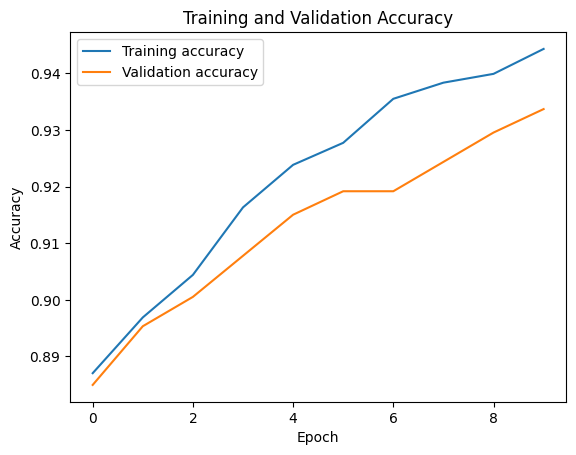

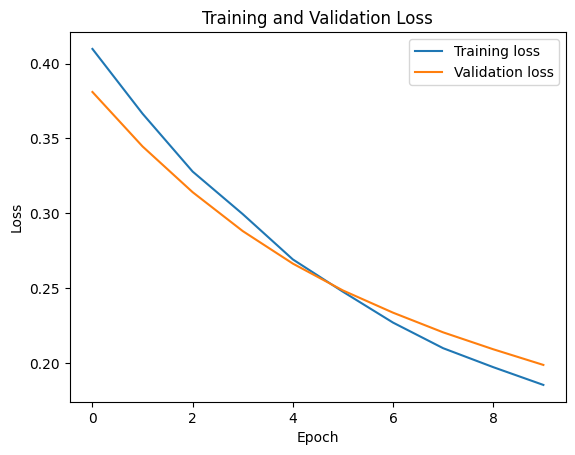

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

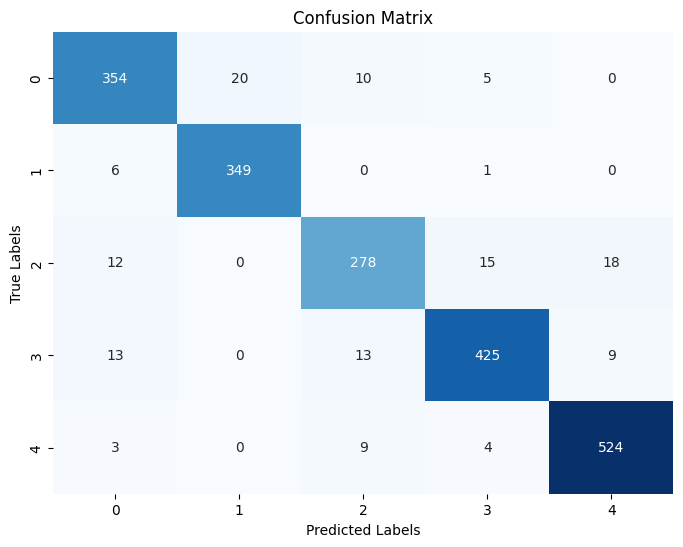

In [ ]:


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:
from sklearn.metrics import classification_report
class_report = classification_report(y_true, y_pred)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       389
           1       0.95      0.98      0.96       356
           2       0.90      0.86      0.88       323
           3       0.94      0.92      0.93       460
           4       0.95      0.97      0.96       540

    accuracy                           0.93      2068
   macro avg       0.93      0.93      0.93      2068
weighted avg       0.93      0.93      0.93      2068



In [ ]:

# Assuming X_scaled and y_categorical are already defined and preprocessed

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store scores for each fold
fold_accuracies = []
fold_f1_scores = []
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Loop through each fold
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    # Reshape input for LSTM layers
    X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

    # Define the model
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    #model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=30, validation_split=0.2, verbose=0)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
    print(f'Fold Test Accuracy: {accuracy * 100:.2f}%')
    fold_accuracies.append(accuracy)

    # Predict and calculate F1 score
    y_pred_probs = model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'Fold F1 Score: {f1:.4f}')
    fold_f1_scores.append(f1)
    class_report = classification_report(y_true, y_pred)
    print("Classification Report:\n", class_report)


# Calculate average accuracy and F1 score across all folds
avg_accuracy = np.mean(fold_accuracies)
avg_f1_score = np.mean(fold_f1_scores)

print(f'Average Test Accuracy: {avg_accuracy * 100:.2f}%')
print(f'Average F1 Score: {avg_f1_score:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold Test Accuracy: 87.82%
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
Fold F1 Score: 0.8805
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.98      0.91       248
           1       0.98      0.98      0.98       238
           2       0.68      0.94      0.79       230
           3       0.96      0.73      0.83       313
           4       0.97      0.83      0.89       350

    accuracy                           0.88      1379
   macro avg       0.89      0.89      0.88      1379
weighted avg       0.90      0.88      0.88      1379



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold Test Accuracy: 84.70%
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Fold F1 Score: 0.8476
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       274
           1       0.97      0.98      0.97       251
           2       0.58      0.97      0.73       192
           3       0.95      0.74      0.83       314
           4       0.97      0.69      0.81       348

    accuracy                           0.85      1379
   macro avg       0.86      0.87      0.85      1379
weighted avg       0.89      0.85      0.85      1379



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold Test Accuracy: 86.08%
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
Fold F1 Score: 0.8596
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90       280
           1       0.97      0.96      0.96       256
           2       0.61      0.96      0.74       193
           3       0.96      0.75      0.84       312
           4       0.99      0.75      0.85       338

    accuracy                           0.86      1379
   macro avg       0.87      0.88      0.86      1379
weighted avg       0.89      0.86      0.86      1379



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold Test Accuracy: 85.92%
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold F1 Score: 0.8596
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.98      0.89       266
           1       0.99      0.95      0.97       257
           2       0.63      0.96      0.76       210
           3       0.95      0.72      0.82       302
           4       0.98      0.76      0.86       343

    accuracy                           0.86      1378
   macro avg       0.87      0.87      0.86      1378
weighted avg       0.89      0.86      0.86      1378



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold Test Accuracy: 84.83%
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Fold F1 Score: 0.8482
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90       249
           1       0.96      0.97      0.97       266
           2       0.58      0.97      0.73       194
           3       0.93      0.69      0.79       327
           4       0.98      0.76      0.86       342

    accuracy                           0.85      1378
   macro avg       0.86      0.87      0.85      1378
weighted avg       0.89      0.85      0.85      1378

Average Test Accuracy: 85.87%
Average F1 Score: 0.8591


### **IEMOCAP**

In [6]:
features_df = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/IEMOCAP//features_labeled.csv_majorColumn.csv')
features_df['Emotion'] = features_df['Emotion'].str.strip().str.lower()
features_df

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shared drives/CS298/CS 297/IEMOCAP//features_labeled.csv_majorColumn.csv'

In [ ]:
emotion_counts = features_df['Emotion'].str.strip().str.lower().value_counts()

# Print unique values along with their counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

happy: 297
neutral: 291
angry: 273
sad: 271
nervous: 131
excited: 11


In [ ]:
# Standardize the case and remove leading/trailing whitespace
features_df['Emotion'] = features_df['Emotion'].str.strip().str.lower()

# Replace "excited" with "happy"
features_df['Emotion'] = features_df['Emotion'].replace('excited', 'happy')

# Recalculate the emotion counts
emotion_counts = features_df['Emotion'].value_counts()

# Print the updated counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")


happy: 308
neutral: 291
angry: 273
sad: 271
nervous: 131


In [ ]:
features_df = features_df[~features_df['Emotion'].str.contains('nervous', na=False)]



In [ ]:
# Recalculate the emotion counts
emotion_counts = features_df['Emotion'].value_counts()

# Print the updated counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

happy: 308
neutral: 291
angry: 273
sad: 271


In [ ]:

X = features_df.iloc[:, :81]
y = features_df['Emotion']
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled = X
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

In [ ]:

def build_model(X_train_reshaped):
    inputs = Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
    x = Bidirectional(LSTM(units=128, return_sequences=True))(inputs)  # Replace hp.Int with fixed value
    #x = Dropout(rate=0.25)(x)  # Replace hp.Float with fixed value
    # Attention layer
    query_value_attention_seq = Attention()([x, x])
    x = LSTM(64)(query_value_attention_seq)
    outputs = Dense(y_categorical.shape[1], activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
# Assuming X_scaled and y_categorical are already defined and preprocessed

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Arrays to store scores for each fold
fold_accuracies = []
fold_f1_scores = []
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
fold = 1
# Loop through each fold
for train_index, test_index in kf.split(X_scaled):
    print('Fold ', fold)
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    # Reshape input for LSTM layers
    X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    '''
    # Define the model
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    #model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.2))
    model.add(Dense(y_categorical.shape[1], activation='softmax'))
    '''
    model = build_model(X_train_reshaped)
    # Compile the model
    optimizer = Adam(learning_rate=0.00001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_reshaped, y_train, epochs=50, batch_size=30, validation_split=0.2, verbose=2)

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
    print(f'Fold Test Accuracy: {accuracy * 100:.2f}%')
    fold_accuracies.append(accuracy)

    # Predict and calculate F1 score
    y_pred_probs = model.predict(X_test_reshaped)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f'F1 Score: {f1:.4f}')
    fold_f1_scores.append(f1)
    class_report = classification_report(y_true, y_pred)
    print("Classification Report:\n", class_report)
    fold+=1
    print('----------------------------------------------')


# Calculate average accuracy and F1 score across all folds
avg_accuracy = np.mean(fold_accuracies)
avg_f1_score = np.mean(fold_f1_scores)

print(f'Average Test Accuracy: {avg_accuracy * 100:.2f}%')
print(f'Average F1 Score: {avg_f1_score:.4f}')


Fold  1
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


25/25 - 3s - 110ms/step - accuracy: 0.2367 - loss: 1.3858 - val_accuracy: 0.2842 - val_loss: 1.3818
Epoch 2/50
25/25 - 0s - 7ms/step - accuracy: 0.2695 - loss: 1.3834 - val_accuracy: 0.3497 - val_loss: 1.3800
Epoch 3/50
25/25 - 0s - 7ms/step - accuracy: 0.3092 - loss: 1.3810 - val_accuracy: 0.3880 - val_loss: 1.3782
Epoch 4/50
25/25 - 0s - 7ms/step - accuracy: 0.3297 - loss: 1.3787 - val_accuracy: 0.4098 - val_loss: 1.3763
Epoch 5/50
25/25 - 0s - 7ms/step - accuracy: 0.3406 - loss: 1.3764 - val_accuracy: 0.4481 - val_loss: 1.3746
Epoch 6/50
25/25 - 0s - 7ms/step - accuracy: 0.3707 - loss: 1.3741 - val_accuracy: 0.4536 - val_loss: 1.3728
Epoch 7/50
25/25 - 0s - 7ms/step - accuracy: 0.3926 - loss: 1.3718 - val_accuracy: 0.4645 - val_loss: 1.3711
Epoch 8/50
25/25 - 0s - 7ms/step - accuracy: 0.4118 - loss: 1.3695 - val_accuracy: 0.4754 - val_loss: 1.3692
Epoch 9/50
25/25 - 0s - 7ms/step - accuracy: 0.4200 - loss: 1.3672 - val_accuracy: 0.4809 - val_loss: 1.3674
Epoch 10/50
25/25 - 0s - 7ms

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
F1 Score: 0.5691
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.68      0.65        65
           1       0.61      0.58      0.59        57
           2       0.52      0.33      0.40        52
           3       0.56      0.73      0.63        55

    accuracy                           0.59       229
   macro avg       0.58      0.58      0.57       229
weighted avg       0.58      0.59      0.58       229

----------------------------------------------
Fold  2
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


25/25 - 3s - 107ms/step - accuracy: 0.2544 - loss: 1.3862 - val_accuracy: 0.2623 - val_loss: 1.3877
Epoch 2/50
25/25 - 0s - 7ms/step - accuracy: 0.2859 - loss: 1.3830 - val_accuracy: 0.3005 - val_loss: 1.3852
Epoch 3/50
25/25 - 0s - 7ms/step - accuracy: 0.3174 - loss: 1.3800 - val_accuracy: 0.3279 - val_loss: 1.3824
Epoch 4/50
25/25 - 0s - 7ms/step - accuracy: 0.3393 - loss: 1.3770 - val_accuracy: 0.3607 - val_loss: 1.3797
Epoch 5/50
25/25 - 0s - 7ms/step - accuracy: 0.3570 - loss: 1.3740 - val_accuracy: 0.3989 - val_loss: 1.3771
Epoch 6/50
25/25 - 0s - 7ms/step - accuracy: 0.3776 - loss: 1.3711 - val_accuracy: 0.4317 - val_loss: 1.3745
Epoch 7/50
25/25 - 0s - 7ms/step - accuracy: 0.3995 - loss: 1.3682 - val_accuracy: 0.4645 - val_loss: 1.3720
Epoch 8/50
25/25 - 0s - 7ms/step - accuracy: 0.4145 - loss: 1.3653 - val_accuracy: 0.4809 - val_loss: 1.3694
Epoch 9/50
25/25 - 0s - 7ms/step - accuracy: 0.4227 - loss: 1.3623 - val_accuracy: 0.4809 - val_loss: 1.3670
Epoch 10/50
25/25 - 0s - 7ms

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
F1 Score: 0.5137
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.60      0.58        53
           1       0.47      0.43      0.45        53
           2       0.51      0.34      0.41        61
           3       0.54      0.71      0.62        62

    accuracy                           0.52       229
   macro avg       0.52      0.52      0.51       229
weighted avg       0.52      0.52      0.51       229

----------------------------------------------
Fold  3
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


25/25 - 3s - 123ms/step - accuracy: 0.1915 - loss: 1.3978 - val_accuracy: 0.1475 - val_loss: 1.4014
Epoch 2/50
25/25 - 0s - 7ms/step - accuracy: 0.2202 - loss: 1.3949 - val_accuracy: 0.1366 - val_loss: 1.3991
Epoch 3/50
25/25 - 0s - 7ms/step - accuracy: 0.2312 - loss: 1.3921 - val_accuracy: 0.1311 - val_loss: 1.3969
Epoch 4/50
25/25 - 0s - 7ms/step - accuracy: 0.2544 - loss: 1.3894 - val_accuracy: 0.1530 - val_loss: 1.3947
Epoch 5/50
25/25 - 0s - 7ms/step - accuracy: 0.2804 - loss: 1.3866 - val_accuracy: 0.1749 - val_loss: 1.3926
Epoch 6/50
25/25 - 0s - 7ms/step - accuracy: 0.2859 - loss: 1.3839 - val_accuracy: 0.1858 - val_loss: 1.3905
Epoch 7/50
25/25 - 0s - 7ms/step - accuracy: 0.3064 - loss: 1.3811 - val_accuracy: 0.2131 - val_loss: 1.3884
Epoch 8/50
25/25 - 0s - 7ms/step - accuracy: 0.3352 - loss: 1.3784 - val_accuracy: 0.2732 - val_loss: 1.3862
Epoch 9/50
25/25 - 0s - 7ms/step - accuracy: 0.3694 - loss: 1.3757 - val_accuracy: 0.2842 - val_loss: 1.3842
Epoch 10/50
25/25 - 0s - 7ms

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
F1 Score: 0.5143
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.73      0.56        48
           1       0.65      0.48      0.55        67
           2       0.54      0.21      0.30        63
           3       0.54      0.82      0.65        51

    accuracy                           0.53       229
   macro avg       0.55      0.56      0.51       229
weighted avg       0.55      0.53      0.51       229

----------------------------------------------
Fold  4
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


25/25 - 3s - 108ms/step - accuracy: 0.2555 - loss: 1.3868 - val_accuracy: 0.2459 - val_loss: 1.3885
Epoch 2/50
25/25 - 0s - 7ms/step - accuracy: 0.2855 - loss: 1.3841 - val_accuracy: 0.2842 - val_loss: 1.3869
Epoch 3/50
25/25 - 0s - 7ms/step - accuracy: 0.3115 - loss: 1.3816 - val_accuracy: 0.2732 - val_loss: 1.3852
Epoch 4/50
25/25 - 0s - 7ms/step - accuracy: 0.3374 - loss: 1.3790 - val_accuracy: 0.3005 - val_loss: 1.3834
Epoch 5/50
25/25 - 0s - 7ms/step - accuracy: 0.3593 - loss: 1.3765 - val_accuracy: 0.3115 - val_loss: 1.3817
Epoch 6/50
25/25 - 0s - 7ms/step - accuracy: 0.3798 - loss: 1.3740 - val_accuracy: 0.3388 - val_loss: 1.3800
Epoch 7/50
25/25 - 0s - 7ms/step - accuracy: 0.3907 - loss: 1.3714 - val_accuracy: 0.3443 - val_loss: 1.3783
Epoch 8/50
25/25 - 0s - 7ms/step - accuracy: 0.4071 - loss: 1.3689 - val_accuracy: 0.3497 - val_loss: 1.3766
Epoch 9/50
25/25 - 0s - 7ms/step - accuracy: 0.4180 - loss: 1.3664 - val_accuracy: 0.3607 - val_loss: 1.3749
Epoch 10/50
25/25 - 0s - 7ms

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
F1 Score: 0.5351
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.50      0.49        52
           1       0.54      0.47      0.50        66
           2       0.52      0.41      0.46        59
           3       0.59      0.82      0.69        51

    accuracy                           0.54       228
   macro avg       0.53      0.55      0.54       228
weighted avg       0.53      0.54      0.53       228

----------------------------------------------
Fold  5
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


25/25 - 3s - 114ms/step - accuracy: 0.2049 - loss: 1.3888 - val_accuracy: 0.2568 - val_loss: 1.3854
Epoch 2/50
25/25 - 0s - 7ms/step - accuracy: 0.2322 - loss: 1.3857 - val_accuracy: 0.3060 - val_loss: 1.3828
Epoch 3/50
25/25 - 0s - 7ms/step - accuracy: 0.2760 - loss: 1.3826 - val_accuracy: 0.3224 - val_loss: 1.3803
Epoch 4/50
25/25 - 0s - 7ms/step - accuracy: 0.3033 - loss: 1.3797 - val_accuracy: 0.3552 - val_loss: 1.3777
Epoch 5/50
25/25 - 0s - 7ms/step - accuracy: 0.3265 - loss: 1.3767 - val_accuracy: 0.3661 - val_loss: 1.3751
Epoch 6/50
25/25 - 0s - 7ms/step - accuracy: 0.3511 - loss: 1.3738 - val_accuracy: 0.3880 - val_loss: 1.3726
Epoch 7/50
25/25 - 0s - 7ms/step - accuracy: 0.3839 - loss: 1.3708 - val_accuracy: 0.3880 - val_loss: 1.3701
Epoch 8/50
25/25 - 0s - 7ms/step - accuracy: 0.3962 - loss: 1.3679 - val_accuracy: 0.4098 - val_loss: 1.3676
Epoch 9/50
25/25 - 0s - 7ms/step - accuracy: 0.4112 - loss: 1.3650 - val_accuracy: 0.4208 - val_loss: 1.3651
Epoch 10/50
25/25 - 0s - 7ms

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
F1 Score: 0.4851
Classification Report:
               precision    recall  f1-score   support

           0       0.54      0.58      0.56        55
           1       0.54      0.46      0.50        65
           2       0.52      0.20      0.29        56
           3       0.47      0.83      0.60        52

    accuracy                           0.51       228
   macro avg       0.52      0.52      0.49       228
weighted avg       0.52      0.51      0.48       228

----------------------------------------------
Average Test Accuracy: 53.80%
Average F1 Score: 0.5234


# Trying the major label

In [ ]:
df = pd.read_csv('/content/drive/Shared drives/CS298/CS 297/IEMOCAP/IEMOCAP_Updated.csv')
df.dropna(subset=['Major'], inplace=True)
df['Audio_Uttrance_Path'] = df['Audio_Uttrance_Path'].str.replace('/content/drive/My Drive', '/content/drive/Shareddrives/CS298')
df.drop(columns=['Arousal', 'Valence', 'Dominance'], inplace=True)
df.drop(columns=[ 'dom', 'val', 'act', 'dimension', 'category', 'Major_Emotion'], inplace=True)
df.head()

,Session,Conversation,Audio_Path,Speaker_id,Transcript,Time_Frame,Major_emotion,Audio_Uttrance_Path,Major,New_Category,Final_class,Unnamed: 20
0,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M000,Good God.,006.2551-008.1400,Frustration,/content/drive/Shareddrives/CS298/CS 297/IEMOC...,Fear,Nervous,NaN,NaN
1,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_F000,Do you think it's them?,007.7500-009.1900,Frustration,/content/drive/Shareddrives/CS298/CS 297/IEMOC...,Fear,Nervous,NaN,NaN
2,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M001,I wonder.,008.6300-009.6700,Fear,/content/drive/Shareddrives/CS298/CS 297/IEMOC...,Fear,Nervous,NaN,NaN
3,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_F001,Nobody knows we're here except Freda and she w...,009.2300-011.8600,Frustration,/content/drive/Shareddrives/CS298/CS 297/IEMOC...,Fear,Nervous,NaN,NaN
4,Session4,Ses04F_script03_1,/content/drive/My Drive/CS 297/IEMOCAP/Session...,Ses04F_script03_1_M002,It must be them then.,011.4300-012.7900,Fear,/content/drive/Shareddrives/CS298/CS 297/IEMOC...,Fear,Nervous,NaN,NaN


In [ ]:
import librosa
import numpy as np
import scipy
from scipy.signal import lfilter, hamming
import pysptk
from scipy.io import wavfile
import noisereduce as nr

def extract_extended_features(audio_path):
    # Load the audio file
    y, sr = librosa.load(audio_path, sr=16000, mono=True)

    # Reduce noise using noisereduce
    # y = nr.reduce_noise(y=y, sr=sr, thresh_n_mult_nonstationary=2, stationary=False)

    # Features dictionary
    features = {}

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=45)
    for i, mfcc in enumerate(mfccs):
        features[f'MFCC_{i}'] = np.mean(mfcc)

    # Pitch
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_mean = np.mean(pitches[pitches > 0])
    pitch_std = np.std(pitches[pitches > 0])
    features['Pitch_mean'] = pitch_mean
    features['Pitch_std'] = pitch_std

    # Energy
    rmse = librosa.feature.rms(y=y)
    features['Energy_mean'] = np.mean(rmse)
    features['Energy_std'] = np.std(rmse)

    # Spectral Centroid
    spec_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['Spectral_Centroid_mean'] = np.mean(spec_centroids)
    features['Spectral_Centroid_std'] = np.std(spec_centroids)

    # Spectral Bandwidth, Rolloff, RMS Energy
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['Spectral_Bandwidth_Mean'] = np.mean(spectral_bandwidth)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['Spectral_Rolloff_Mean'] = np.mean(rolloff)
    rms_energy = librosa.feature.rms(y=y)
    features['RMS_Energy_Mean'] = np.mean(rms_energy)

    # Chroma Features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    for i, chroma in enumerate(chroma_stft):
        features[f'Chroma{i}'] = np.mean(chroma)

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y)
    features['ZCR_mean'] = np.mean(zcr)
    features['ZCR_std'] = np.std(zcr)

    # Loudness (using Energy)
    S, phase = librosa.magphase(librosa.stft(y))
    rms_s = librosa.feature.rms(S=S)
    features['Loudness'] = np.mean(librosa.amplitude_to_db(rms_s, ref=np.max))

    # Mel-Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    features['Mel_Spec_Mean'] = np.mean(mel_spec)

    # LPC - Linear Predictive Coefficients
    lpc_coefficients = librosa.lpc(y, order=10)
    for i, coeff in enumerate(lpc_coefficients):
        features[f'LPC_{i}'] = coeff

    return features


ImportError: cannot import name 'hamming' from 'scipy.signal' (/usr/local/lib/python3.10/dist-packages/scipy/signal/__init__.py)

In [ ]:
merged_df = df[['Speaker_id', 'Transcript', 'Major']].rename(columns={'Major': 'Emotion'})
emotion_mapping = {
    'Neutral state': 'neutral',
    'Frustration': 'sad',
    'Anger': 'angry',
    'Surprise': None,  # Assuming 'Surprise' to 'neutral' if not sure where to map
    'Disgust': None,  # Mapping 'Disgust' to 'angry' or consider removing if not relevant
    'Other': None,  # Remove 'Other' or map if it can be categorized
    'Sadness': 'sad',
    'Fear': None,  # Assuming 'Fear' to 'neutral' or map to 'angry' based on context
    'Happiness': 'happy',
    'Excited': 'happy'
}

# Apply the mapping to the Emotion column
merged_df['Emotion'] = merged_df['Emotion'].map(emotion_mapping)

# Remove any rows with None as Emotion (unmapped categories)
merged_df = merged_df.dropna(subset=['Emotion'])
merged_df
merged_df['Emotion'] = merged_df['Emotion'].str.strip().str.lower()

merged_df['Emotion'] = merged_df['Emotion'].replace('excited', 'happy')
merged_df = merged_df[~merged_df['Emotion'].str.contains('nervous', na=False)]
# Recalculate the emotion counts
emotion_counts = merged_df['Emotion'].value_counts()

# Print the updated counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")